# TalkingData Mobile User Demographics

## EDA

In [38]:
#-*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
import plotly.plotly as py
import plotly.tools as tls
import re
from mpl_toolkits.basemap import Basemap

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

path = 'data/'

phone_brand_device_model = pd.read_csv(path + 'phone_brand_device_model.csv')
gender_age_train = pd.read_csv(path + 'gender_age_train.csv')
gender_age_test = pd.read_csv(path + 'gender_age_test.csv')
label_categories = pd.read_csv(path + 'label_categories.csv')
events = pd.read_csv(path + 'events.csv')
app_labels = pd.read_csv(path + 'app_labels.csv')
app_events = pd.read_csv(path + 'app_events.csv', dtype = {'event_id' : np.int8, 'app_id' : np.int64, 
                                                   'is_installed' : np.int8, 'is_active' : np.int8})

## 1. Data 구성

1) Data Shape

In [4]:
print('phone_brand_device_model shape : ', phone_brand_device_model.shape)
print('gender_age_train shape : ', gender_age_train.shape)
print('gender_age_test shape : ', gender_age_test.shape)
print('events shape : ', events.shape)
print('app_labels shape : ', app_labels.shape)
print('app_events shape : ', app_events.shape)
print('label_categories shape : ', label_categories.shape)

phone_brand_device_model shape :  (187245, 3)
gender_age_train shape :  (74645, 4)
gender_age_test shape :  (112071, 1)
events shape :  (3252950, 5)
app_labels shape :  (459943, 2)
app_events shape :  (32473067, 4)
label_categories shape :  (930, 2)


2) Data 변수 구성

In [35]:
print('* gender_age_train ')
print('  - device_id  : ', len(gender_age_train.device_id.unique()))
print('  - gender  : ', len(gender_age_train.gender.unique()))
print('  - age  : ', len(gender_age_train.age.unique()))
print('  - group  : ', len(gender_age_train.group.unique()))
print('')

print('* gender_age_test ')
print('  - gender_age_test  : ', len(gender_age_test.device_id.unique()))
print('')

print('* phone_brand_device_model ')
print('  - device_id  : ', len(phone_brand_device_model.device_id.unique()))
print('  - phone_brand  : ', len(phone_brand_device_model.phone_brand.unique()))
print('  - device_model  : ', len(phone_brand_device_model.device_model.unique()))
print('')

print('* events ')
print('  - device_id  : ', len(events.device_id.unique()))
print('  - event_id  : ', len(events.event_id.unique()))
print('  - timestamp  : ', len(events.timestamp.unique()))
print('  - longitute  : ', len(events.longitude.unique()))
print('  - latitue  : ', len(events.latitude.unique()))
print('')

print('* app_events ')
print('  - event_id  : ', len(app_events.event_id.unique()))
print('  - app_id  : ', len(app_events.app_id.unique()))
print('  - is_installed  : ', len(app_events.is_installed.unique()))
print('  - is_active  : ', len(app_events.is_active.unique()))
print('')

print('* app_labels ')
print('  - app_id  : ', len(app_labels.app_id.unique()))
print('  - label_id  : ', len(app_labels.label_id.unique()))
print('')

print('* label_categories ')
print('  - label_id  : ', len(label_categories.label_id.unique()))
print('  - category  : ', len(label_categories.category.unique()))

* gender_age_train 
  - device_id  :  74645
  - gender  :  2
  - age  :  85
  - group  :  12

* gender_age_test 
  - gender_age_test  :  112071

* phone_brand_device_model 
  - device_id  :  186716
  - phone_brand  :  131
  - device_model  :  1599

* events 
  - device_id  :  60865
  - event_id  :  3252950
  - timestamp  :  588125
  - longitute  :  3588
  - latitue  :  3086

* app_events 
  - event_id  :  256
  - app_id  :  19237
  - is_installed  :  1
  - is_active  :  2

* app_labels 
  - app_id  :  113211
  - label_id  :  507

* label_categories 
  - label_id  :  930
  - category  :  836


3) 브랜드명 전환

In [40]:
english_phone_brands_mapping = {
    '三星': 'samsung', '天语': 'Ktouch', '海信': 'hisense', '联想': 'lenovo', '欧比': 'obi', '爱派尔': 'ipair',
    '努比亚': 'nubia', '优米': 'youmi', '朵唯': 'dowe', '黑米': 'heymi', '锤子': 'hammer', '酷比魔方': 'koobee',
    '美图': 'meitu', '尼比鲁': 'nibilu', '一加': 'oneplus', '优购': 'yougo', '诺基亚': 'nokia', '糖葫芦': 'candy',
    '中国移动': 'ccmc', '语信': 'yuxin', '基伍': 'kiwu', '青橙': 'greeno', '华硕': 'asus', '夏新': 'panosonic',
    '维图': 'weitu', '艾优尼': 'aiyouni', '摩托罗拉': 'moto', '乡米': 'xiangmi', '米奇': 'micky', '大可乐': 'bigcola',
    '沃普丰': 'wpf', '神舟': 'hasse', '摩乐': 'mole', '飞秒': 'fs', '米歌': 'mige', '富可视': 'fks', '德赛': 'desci',
    '梦米': 'mengmi', '乐视': 'lshi', '小杨树': 'smallt', '纽曼': 'newman', '邦华': 'banghua', 'E派': 'epai', '易派': 'epai',
    '普耐尔': 'pner', '欧新': 'ouxin', '西米': 'ximi', '海尔': 'haier', '波导': 'bodao', '糯米': 'nuomi', '唯米': 'weimi',
    '酷珀': 'kupo', '谷歌': 'google', '昂达': 'ada', '聆韵': 'lingyun', '小米': 'Xiaomi', '华为': 'Huawei', '魅族': 'Meizu',
    '中兴': 'ZTE', '酷派': 'Coolpad', '金立': 'Gionee', 'SUGAR': 'SUGAR', 'OPPO': 'OPPO', 'vivo': 'vivo', 'HTC': 'HTC',
    'LG': 'LG', 'ZUK': 'ZUK', 'TCL': 'TCL', 'LOGO': 'LOGO', 'SUGAR': 'SUGAR', 'Lovme': 'Lovme', 'PPTV': 'PPTV', 'ZOYE': 'ZOYE',
    'MIL': 'MIL', '索尼' : 'Sony', '欧博信' : 'Opssom', '奇酷' : 'Qiku', '酷比' : 'CUBE', '康佳' : 'Konka', '亿通' : 'Yitong',
    '金星数码' : 'JXD', '至尊宝' : 'Monkey King', '百立丰' : 'Hundred Li Feng', '贝尔丰' : 'Bifer', '百加' : 'Bacardi',
    '诺亚信' : 'Noain', '广信' : 'Kingsun', '世纪天元' : 'Ctyon', '青葱' : 'Cong', '果米' : 'Taobao', '斐讯' : 'Phicomm',
    '长虹' : 'Changhong', '欧奇' : 'Oukimobile', '先锋' : 'XFPLAY', '台电' : 'Teclast', '大Q' : 'Daq', '蓝魔' : 'Ramos', '奥克斯' : 'AUX'
}

phone_brand_device_model.phone_brand = phone_brand_device_model.phone_brand.map(pd.Series(english_phone_brands_mapping), na_action='ignore')

# 2. Group - Mobile Brand 비교

- 남성과 여성의 사용 비율 확인을 위해 남성의 이용 비율 조정 (남성 1.8배 많음)
- Scale : 남성 이용자 수 / 1.8 = 여성 이용자 수
<br><br>
- brand 점유 비교
  - 상위 1위 ~ 5위의 brand 점유율 유사 
    - 남성 여성 모두 1~3위가 약 65% 차지, 1~5위가 약 80% 차지
  - 상위 6위 ~ 의 brand의 경우 여성 대비 남성이 다양한 brand를 사용하고 있는 것으로 확인
<br><br>
- 남성과 여성의 brand 선호도
  - 남성과 여성의 brand 선호도 차이 존재
    - 남성 : Xiaomi > Huawei > Samsung > Meizu > OPPO > vivo > Coolpad > lenovo
    - 여성 : Xiaomi > Samsung > Huawei > vivo  > OPPO > Meizu > Coolpad > lenovo <br>
   ▶ 성별에 따른 brand 마케팅 전략 수립
<br><br>   
- Group별 점유율
  - F27-28, M27-28, M29-31 의 모바일 사용 저조 <br>
    ▶ 원인 분석 후 이용자 확대 방안 모색

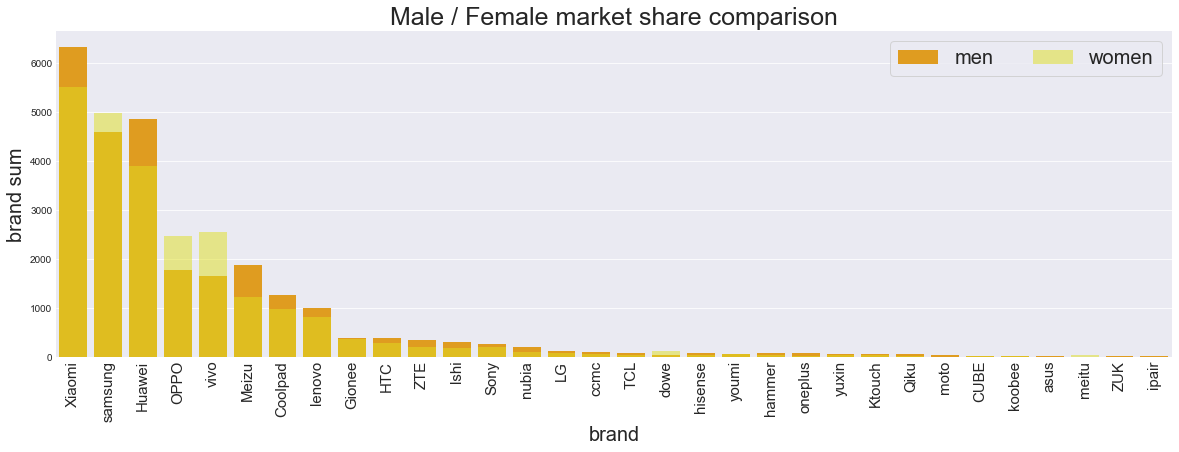

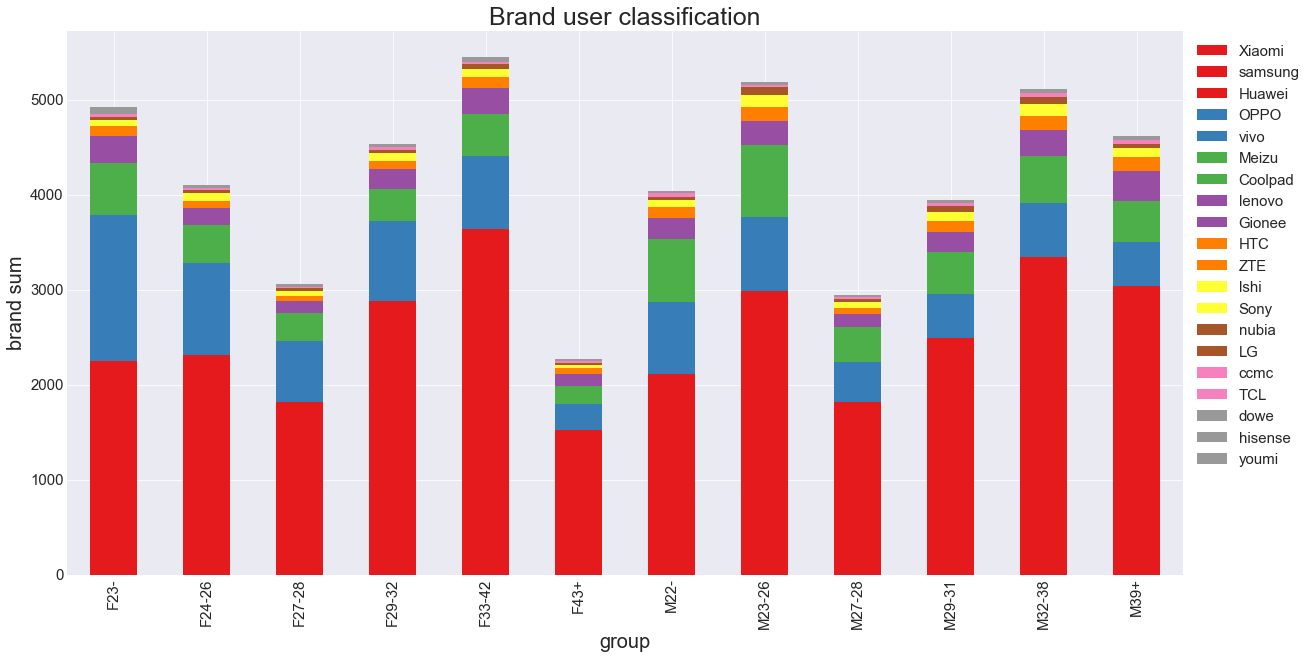

In [42]:
age_phone = pd.merge(gender_age_train, phone_brand_device_model, on = 'device_id')

g_model = pd.DataFrame(age_phone.groupby('phone_brand')['group'].value_counts().unstack())

g_model['sum'] = g_model.sum(axis = 1)
g_model = g_model.sort_values(by = 'sum', ascending = False).reset_index()


# 남성과 여성 이용자수 1:1 구성
g_model.iloc[:,6:-1] = round(g_model.iloc[:,6:-1].apply(lambda x : x/1.8),0)

# 여성 과 남성 분리
g_model_f = g_model.iloc[:,:7]
g_model_m = g_model.iloc[:,7:-1]
g_model_m.insert(0, 'phone_brand', g_model['phone_brand'])

# 제품별 sum
g_model_f['sum'] = g_model_f.sum(axis = 1)
g_model_m['sum'] = g_model_m.sum(axis = 1)

g_model_f = g_model_f
g_model_m = g_model_m

g_model_f['ratio'] = g_model_f['sum'].apply(lambda x : x / g_model_f['sum'].sum(axis = 0))
g_model_m['ratio'] = g_model_m['sum'].apply(lambda x : x / g_model_m['sum'].sum(axis = 0))

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize = (20,6))

pm = sns.barplot(g_model_m.loc[:31, 'phone_brand'], g_model_m.loc[:31, 'sum'], color = 'orange', label = 'men')
pw = sns.barplot(g_model_f.loc[:31, 'phone_brand'], g_model_f.loc[:31, 'sum'], color = 'yellow', label = 'women', alpha=0.5)
              
plt.ylabel('brand sum', fontsize = 20)
plt.xlabel('brand', fontsize = 20)
plt.title('Male / Female market share comparison', fontsize = 25)

ax.legend(ncol = 7, loc='upper right', frameon = True, fontsize = 20)
plt.xticks(rotation='vertical', fontsize = 15)
sns.despine(left=True, bottom=True)


# 그래프용 frame 조정
g_model = g_model.set_index('phone_brand')

g_model_new = pd.DataFrame()
g_model_new['sum'] = g_model.unstack()

g_model_new = g_model_new.reset_index()

# 그룹별 brand 점유율
# cmap Set1 이용시, 점유도에 따른 그루핑
g_model.T.iloc[:-1, :20].plot(kind = 'bar', stacked = True, figsize=(20,10), fontsize = 15, cmap = 'Set1')

plt.legend(bbox_to_anchor = (1,1), fontsize = 15)

plt.ylabel('brand sum', fontsize = 20)
plt.xlabel('group', fontsize = 20)
plt.title('Brand user classification', fontsize = 25)

g_model = g_model.reset_index()

# 3. App 이용 현황

- App 이용 활발한 그룹
  - 남성 : M39+ > M23-26 > M27-28 = M29-31 = M32-38 > M22-
  - 여성 : F27-28 > F23- = F43+ > F29-32
  <br><br>
- Top 5 (카테고리)<br>
   1) Finance <br>
   2) Industry  <br>
   3) Read <br>
   4) Edu <br>
   5) Purchase <br>
   
   - Top 5에 포함된 경우, App 종류는 적지만, 개별 사용량 많음
   - 이외, game의 경우는 App 종류는 많지만, 개별 사용량 적음
<br><br>
- App 이용
  - Finance , Property industry 에 대한 사용량이 절대적으로 많음 
    <br>▶ 모바일을 통한 금융 및 산업 활동 활발
  - 정보 획득을 위한 Read, Edu 이용 활발
  - App을 통한 쇼핑 등의 구매 활동 활발


In [29]:
# evnet_id 에서 minus값 제거

app_events = app_events[(app_events.event_id > 0)]

# time stamp에서 time 이용
events['timestamp'].replace('-', '', regex = True, inplace = True)
events['timestamp'].replace(':', '', regex = True, inplace = True)
events['timestamp'].replace(' ', '', regex = True, inplace = True)

events['year'] = events['timestamp'].map(lambda x: x[0:4])
events['month'] = events['timestamp'].map(lambda x: x[4:6])
events['day'] = events['timestamp'].map(lambda x: x[6:8])
events['time'] = events['timestamp'].map(lambda x: x[8:10])

events.drop(['timestamp'], axis = 1, inplace = True)
events.drop(['year'], axis = 1, inplace = True)

app_label = pd.merge(app_labels, label_categories, on='label_id')
eve_label = pd.merge(app_events, app_label, on='app_id')
eve_label = eve_label.drop(['is_installed', 'is_active', 'app_id'], 1)
even_gen = pd.merge(gender_age_train,events, on = 'device_id')
even_label = pd.merge(even_gen, eve_label, on='event_id')


del app_label, eve_label, even_gen

In [30]:
import re

# 그룹별 많이 사용하는 앱
g_cate = pd.DataFrame()
g_cate['count'] = even_label.groupby(['group', 'category'])['category'].count()

g_cate = g_cate.reset_index()
g_cate['category'] = g_cate['category'].apply(lambda x: x.lower())

g_cate['cate'] = g_cate['category'].apply(lambda x : 'game' if re.match(r'.{,20}( wars|rpg|game|puzzle|chess|simul|lol|poker|gam[bi]|shooting|mmo|ninja|warcraft).{,20}', x) 
                                          else 'comic' if re.match(r'.{,20}(comic|animation).{,20}', x) 
                                          else 'finance' if re.match(r'.{,20}(financ|bank|loan|account| risk|fund|income|exchan|stock|high | profit|insurance|debit|low ).{,20}', x) 
                                          else 'basic' if re.match(r'.{,20}(map|bus$|taxi|calendar|clock|app store|editor|scheduling|weather|email).{,20}', x) 
                                          else 'travel' if re.match(r'.{,20}(korea|train|travel|air |airline|hotel|booki|reserv|aeronautical|region|macao|tour).{,20}', x) 
                                          else 'read' if re.match(r'.{,20}(book |read|poety|books|news|^[a-z]{5,15} 1$|total cost|trendy / cool).{,20}', x)
                                          else 'beauty' if re.match(r'.{,20}(fashion|beauty|korean style).{,20}', x) 
                                          else 'car' if re.match(r'.{,20}(drive|car|vehicles|navigation).{,20}', x) 
                                          else 'purchase' if re.match(r'.{,20}(buy|shopp|seller|coupon|household|commod|point|online malls|pay$).{,20}', x) 
                                          else 'health' if re.match(r'.{,20}(health|medical|doctor|weight).{,20}', x) 
                                          else 'entertain' if re.match(r'.{,20}(music|movie|ktv|ticket|sports|radio|video|weibo|film|entertain).{,20}', x) 
                                          else 'family' if re.match(r'.{,20}(baby|babie|child|parent|pregnant|mother).{,20}', x) 
                                          else 'edu' if re.match(r'.{,20}(study |science|math|exams|educ|class|library|language|college|academic|integrated|foundation|occupational|job|technology|mythology|art and).{,20}', x) 
                                          else 'office' if re.match(r'.{,20}(office|engineer).{,20}', x) 
                                          else 'industry' if re.match(r'.{,20}(industry).{,20}', x) 
                                          else '-')

g_big_cate = pd.DataFrame()
g_big_cate['count'] = g_cate.groupby(['group', 'cate'])['count'].sum()
g_big_cate = g_big_cate.unstack()
g_big_cate = g_big_cate.T.reset_index().drop('level_0', 1).set_index('cate').T
g_big_cate.iloc[4:, :] = round(g_big_cate.iloc[4:, :].apply(lambda x : x/1.8), 0)

g_big_cate_1 = g_big_cate[['industry', 'finance', 'read']]
g_big_cate_2 = g_big_cate.copy().drop(['industry', 'finance', 'read'], 1)

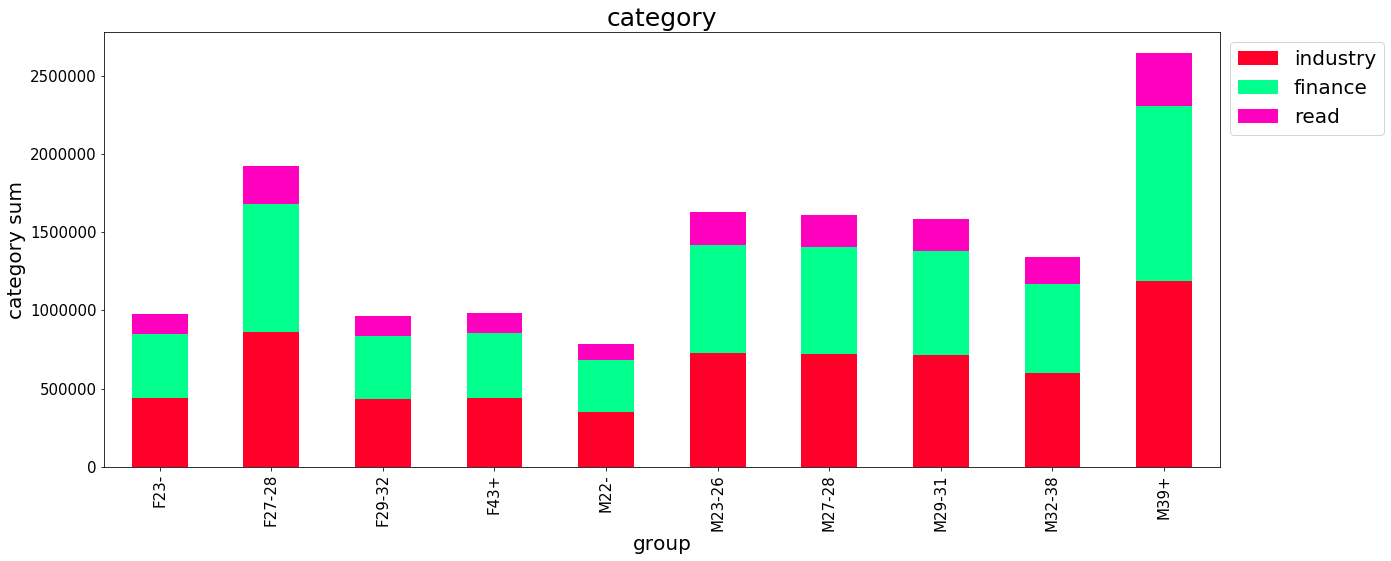

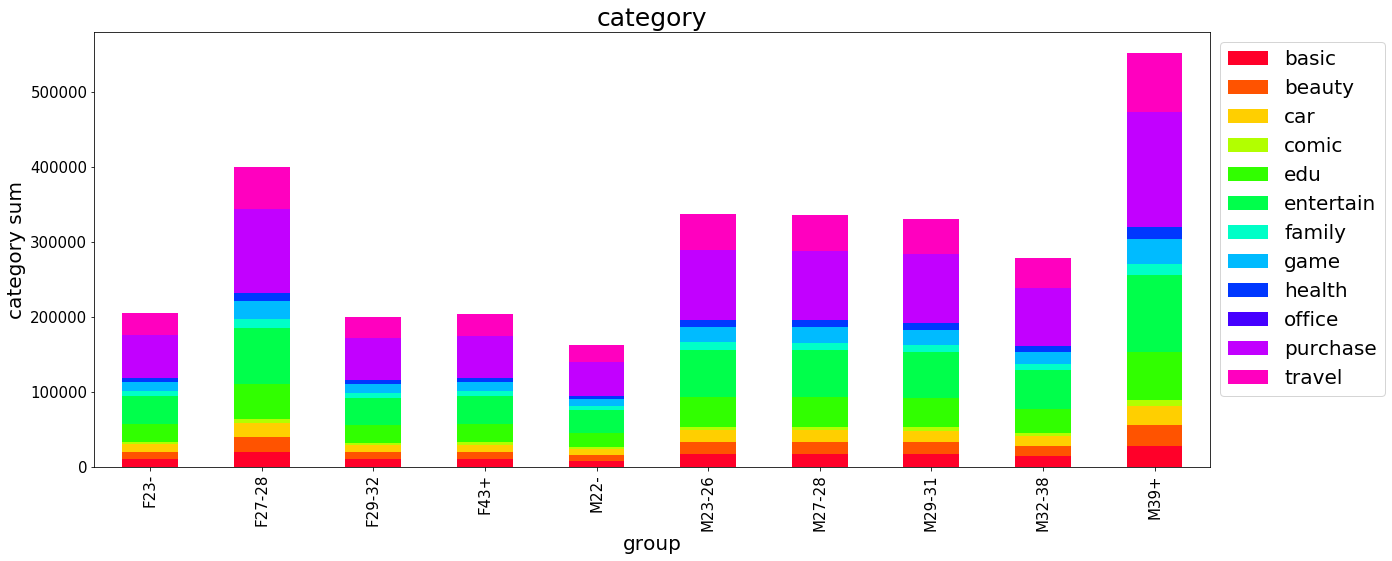

In [31]:
g_big_cate_1.iloc[:, :].plot(kind = 'bar', stacked = True, figsize=(20,8), fontsize = 15, cmap = 'gist_rainbow') 

plt.legend(bbox_to_anchor = (1,1), fontsize = 20)

plt.ylabel('category sum', fontsize = 20)
plt.xlabel('group', fontsize = 20)
plt.title('category', fontsize = 25)


g_big_cate_2.iloc[:, 1:].plot(kind = 'bar', stacked = True, figsize=(20,8), fontsize = 15, cmap = 'gist_rainbow') 

plt.legend(bbox_to_anchor = (1,1), fontsize = 20)

plt.ylabel('category sum', fontsize = 20)
plt.xlabel('group', fontsize = 20)
plt.title('category', fontsize = 25)

# 4. 시간대별 App 이용 현황

* 23시 대비 00시의 App 이용율 증가
* App 이용 Top 5 (23시, 00시)<br>
  1) Game <br>
  2) Finance <br>
  3) Travel <br>
  4) Read <br>
  5) Edu <br>
  ▶ 휴게 및 자산 관리, 정보 습득을 위한 활동
  <br><br>
 
* Data set 결합시 정보 손실이 많아서, 이용 시간대가 00, 23시로 제한되어 시간대별 이용자 분석 제한됨
  (향후 Data 추가를 통해 시간대별 이용자 분석 강화 가능)

In [98]:
# 시간별 많이 사용하는 앱
g_time = pd.DataFrame()
g_time['count'] = even_label.groupby(['group', 'time', 'category'])['time'].count()

g_time = g_time.reset_index()
g_time['category'] = g_time['category'].apply(lambda x: x.lower())

g_time['cate'] = g_time['category'].apply(lambda x : 'game' if re.match(r'.{,20}( wars|rpg|game|puzzle|chess|simul|lol|poker|gam[bi]|shooting|mmo|ninja|warcraft).{,20}', x) 
                                          else 'comic' if re.match(r'.{,20}(comic|animation).{,20}', x) 
                                          else 'finance' if re.match(r'.{,20}(financ|bank|loan|account| risk|fund|income|exchan|stock|high | profit|insurance|debit|low ).{,20}', x) 
                                          else 'basic' if re.match(r'.{,20}(map|bus$|taxi|calendar|clock|app store|editor|scheduling|weather|email).{,20}', x) 
                                          else 'travel' if re.match(r'.{,20}(korea|train|travel|air |airline|hotel|booki|reserv|aeronautical|region|macao|tour).{,20}', x) 
                                          else 'read' if re.match(r'.{,20}(book |read|poety|books|news|^[a-z]{5,15} 1$|total cost|trendy / cool).{,20}', x)
                                          else 'beauty' if re.match(r'.{,20}(fashion|beauty|korean style).{,20}', x) 
                                          else 'car' if re.match(r'.{,20}(drive|car|vehicles|navigation).{,20}', x) 
                                          else 'purchase' if re.match(r'.{,20}(buy|shopp|seller|coupon|household|commod|point|online malls|pay$).{,20}', x) 
                                          else 'health' if re.match(r'.{,20}(health|medical|doctor|weight).{,20}', x) 
                                          else 'entertain' if re.match(r'.{,20}(music|movie|ktv|ticket|sports|radio|video|weibo|film|entertain).{,20}', x) 
                                          else 'family' if re.match(r'.{,20}(baby|babie|child|parent|pregnant|mother).{,20}', x) 
                                          else 'edu' if re.match(r'.{,20}(study |science|math|exams|educ|class|library|language|college|academic|integrated|foundation|occupational|job|technology|mythology|art and).{,20}', x) 
                                          else 'office' if re.match(r'.{,20}(office|engineer).{,20}', x) 
                                          else 'industry' if re.match(r'.{,20}(industry).{,20}', x) 
                                          else '-')

In [145]:
g_time_cate = pd.DataFrame()
g_time_cate['count'] = g_time.groupby(['time', 'cate'])['cate'].count()


g_g_cate = pd.DataFrame()
g_g_cate['count'] = g_time.groupby(['time', 'group', 'cate'])['cate'].count()

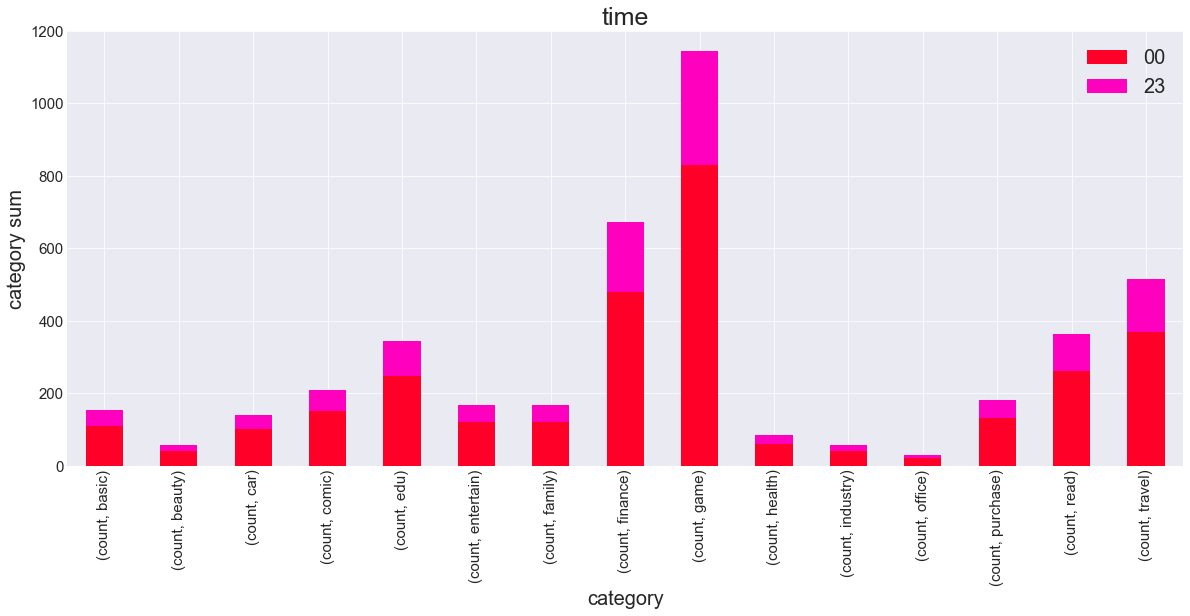

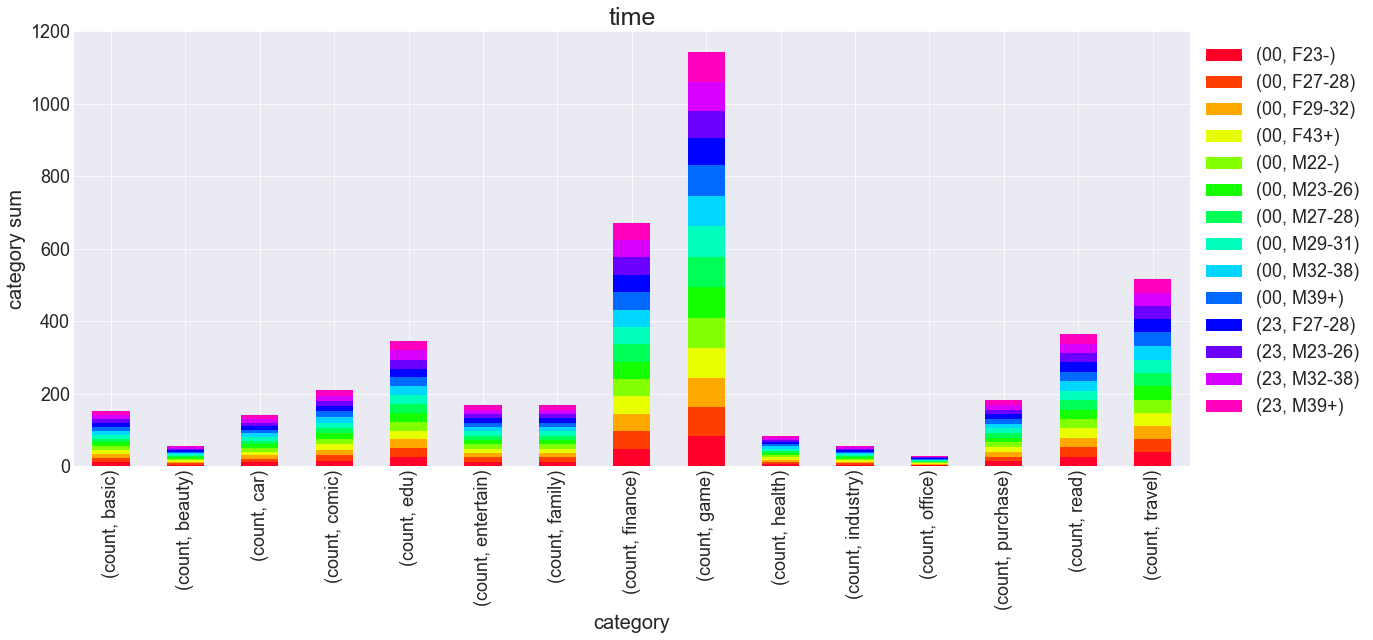

In [191]:
g_time_cate.iloc[:, 1:].T.plot(kind = 'bar', stacked = True, figsize=(20,8), fontsize = 15, cmap = 'gist_rainbow') 

plt.legend(bbox_to_anchor = (1,1), fontsize = 20)

plt.ylabel('category sum', fontsize = 20)
plt.xlabel('category', fontsize = 20)
plt.title('time', fontsize = 25)

g_g_cate.iloc[:, 1:].T.plot(kind = 'bar', stacked = True, figsize=(20,8), fontsize = 18, cmap = 'gist_rainbow') 

plt.legend(bbox_to_anchor = (1,1), fontsize = 18)

plt.ylabel('category sum', fontsize = 20)
plt.xlabel('category', fontsize = 20)
plt.title('time', fontsize = 25)

## 5. 이용자 분포

  - 베이징, 톈진, 상하이, 홍콩, 청두시 등 도심 지역에 분포
  - 여성에 비해 남성의 분포가 세밀하고, 지역 퍼짐이 넓은 경향 보임
  <br><br>
  - 사회 활동이 활발할 것으로 예상되는 여성 24-28세의 모바일 사용 저조한 상태 <br>
    ▶ 원인 파악을 통한 사용자 확대 방안 모색
  

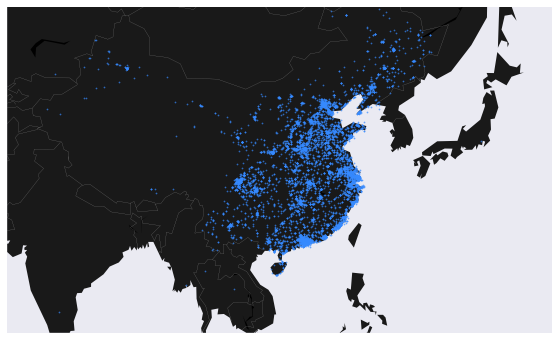

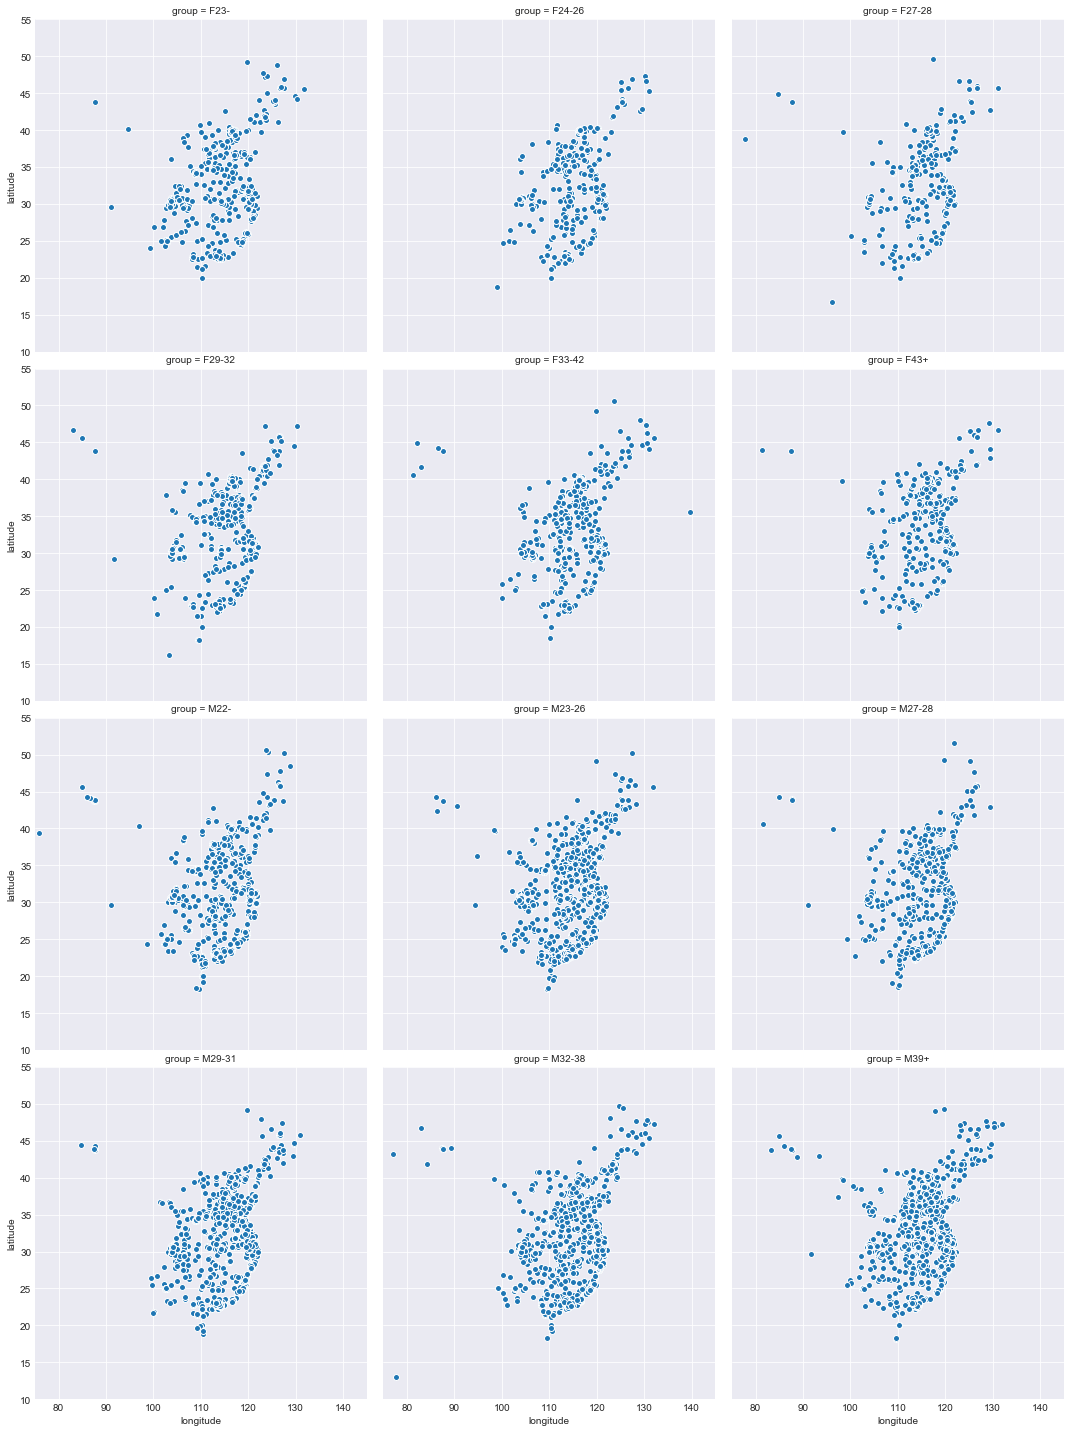

In [44]:
devi_dup_gen = pd.merge(events, gender_age_train, on = 'device_id')

devi_dup_gen = devi_dup_gen.drop_duplicates(subset=['device_id'], keep='first')

# 원본 값으로 표시한 것

plt.figure(1, figsize=(12,6))

g1 = Basemap(projection = 'merc', llcrnrlon = 70, llcrnrlat = 10, urcrnrlon = 150, urcrnrlat = 50)
g1.fillcontinents(color='#191919', lake_color = '#000000')
g1.drawcountries(linewidth = 0.1, color = 'w')

geo = g1(devi_dup_gen['longitude'].tolist(), devi_dup_gen['latitude'].tolist())
g1.scatter(geo[0], geo[1], s = 3, c = '#368AFF', lw = 0, alpha = 0.7, zorder= 5)

plt.show()

# 연령대별 분포

g = sns.FacetGrid(devi_dup_gen, col='group', col_wrap = 3, size=5, ylim=(0, 10), 
                  col_order=['F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+', 
                             'M22-', 'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'])
g = (g.map(plt.scatter, 'longitude', 'latitude', edgecolor = 'w').set(xlim=(75,145), ylim=(10, 55))
     .fig.subplots_adjust(wspace=.05, hspace=.05))
